#

# UFO Sighting Analysis

A small test notebook to look at the time series and geospatial distriution of UFO sightings as recorded in this __[kaggle dataset](https://www.kaggle.com/datasets/jonwright13/ufo-sightings-around-the-world-better)__.

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from folium import plugins
import matplotlib.pyplot as plt
import os, sys
import sklearn as sk
import sweetviz as sv
import dtale
import geopandas 
import calendar
from datetime import datetime

sns.set_palette("flare")
sns.set_style('darkgrid')

Create a dataframe of the data file and check both the header for an example of the data structure

In [133]:
df = pd.read_csv(os.getcwd()+"/ufo-sightings-transformed.csv").drop(columns=["Unnamed: 0"])
df.sample(10)


,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,Country,Region,Locale,latitude,longitude,UFO_shape,length_of_encounter_seconds,Encounter_Duration,Description
73859,2002-09-12 16:00:00,12/23/2002,2002,9,16,Autumn,USA,United States,North Carolina,Charlotte,35.226944,-80.843333,Cigar,2.0,a few seconds,White cigar...
57237,2012-07-15 03:00:00,8/5/2012,2012,7,3,Summer,USA,United States,Ohio,Columbus,39.961111,-82.998889,Egg,900.0,15 minutes,Flying object in Columbus Ohio July 15th 3am.
58389,2007-07-20 22:00:00,8/7/2007,2007,7,22,Summer,USA,United States,Illinois,Lockport,41.589444,-88.057778,Oval,240.0,4 minutes,Enormous&#44 large shaped disc craft with brig...
34709,2011-03-04 19:00:00,3/10/2011,2011,3,19,Spring,USA,United States,Illinois,Manteno,41.250556,-87.831389,Fireball,4.0,4 secs.,Object Exploded after being struck by lightning
5514,2006-10-30 04:15:00,12/7/2006,2006,10,4,Autumn,USA,United States,Indiana,Hammond,41.673372,-87.508339,Cigar,300.0,5 minutes,I am a locomotive engineer and was driving a t...
21165,2003-12-29 22:30:00,1/17/2004,2003,12,22,Winter,USA,United States,Virginia,Alexandria,38.804722,-77.047222,Fireball,1.0,1 second,Green Fireball decends around Fort Belvoir Vir...
12034,2007-11-02 05:00:00,11/28/2007,2007,11,5,Autumn,CAN,Canada,Northwest Territories,Déline,65.183333,-123.416667,Changing,21600.0,6 hours,WE viewed as illuminated disc like shaped obje...
34728,2013-03-04 19:30:00,4/12/2013,2013,3,19,Spring,USA,United States,Louisiana,Kenner,29.993889,-90.241667,Light,10.0,10 seconds,Two bright flashes and some sort of movement i...
62244,2010-07-04 23:30:00,7/10/2010,2010,7,23,Summer,USA,United States,New York,Cortland,42.601111,-76.180833,Fireball,300.0,5 mins,3 redish orange lights seen over central ny tr...
5255,2001-10-29 22:30:00,8/11/2004,2001,10,22,Autumn,USA,United States,Illinois,Shorewood,41.520000,-88.201667,Disk,30.0,30 seconds,Very large disk with a blue light on the botto...


While it's good to have a quick overview of the data like above, we'd like abit more insight into the utility of the different features we have to work with. One of those being how much of the available data is composed of null values. For that we can just run the isnull method and sum each occurence

In [134]:
df.isnull().sum()

Date_time                         0
date_documented                   0
Year                              0
Month                             0
Hour                              0
Season                            0
Country_Code                    259
Country                         259
Region                          566
Locale                          457
latitude                          0
longitude                         0
UFO_shape                      1930
length_of_encounter_seconds       0
Encounter_Duration                0
Description                      15
dtype: int64

So we see that most of the numeric data types have no null values, while more of the categorical types comprise afew null entries. Its helpful to gauge just how frequent these are though, so we can look at them as a percentage of the total entries

In [135]:
df.isnull().sum()/len(df)

Date_time                      0.000000
date_documented                0.000000
Year                           0.000000
Month                          0.000000
Hour                           0.000000
Season                         0.000000
Country_Code                   0.003224
Country                        0.003224
Region                         0.007046
Locale                         0.005689
latitude                       0.000000
longitude                      0.000000
UFO_shape                      0.024026
length_of_encounter_seconds    0.000000
Encounter_Duration             0.000000
Description                    0.000187
dtype: float64

We see that for the features that do have null entries, these make up less than 1% of the total number, so we can assume they'll have negligible impact on any analysis we run

Further, we can look at ssome of the brief statitical propeties of the dataset

In [136]:
df.describe()

,Year,Month,Hour,latitude,longitude,length_of_encounter_seconds
count,80328.000000,80328.000000,80328.000000,80328.000000,80328.000000,8.032800e+04
mean,2003.850463,6.835026,15.525172,38.124963,-86.772015,9.017336e+03
std,10.426547,3.234876,7.753750,10.469146,39.697805,6.202322e+05
min,1906.000000,1.000000,0.000000,-82.862752,-176.658056,1.000000e-03
25%,2001.000000,4.000000,10.000000,34.134722,-112.073333,3.000000e+01
50%,2006.000000,7.000000,19.000000,39.412500,-87.903611,1.800000e+02
75%,2011.000000,9.000000,21.000000,42.788333,-78.755000,6.000000e+02
max,2014.000000,12.000000,23.000000,72.700000,178.441900,9.783600e+07


As a final check, it could also be good to check the datatypes of each column, and assign new datatypes in order to make plotting easier

In [137]:
df.dtypes

Date_time                       object
date_documented                 object
Year                             int64
Month                            int64
Hour                             int64
Season                          object
Country_Code                    object
Country                         object
Region                          object
Locale                          object
latitude                       float64
longitude                      float64
UFO_shape                       object
length_of_encounter_seconds    float64
Encounter_Duration              object
Description                     object
dtype: object

In [138]:
types = {
    "Season":"category",
    "Country":"category",
    "Region":"category",
    "UFO_shape":"category",
    "Description":"string"
}

df['Date_time'] = pd.to_datetime(df['Date_time'])
df['date_documented'] = pd.to_datetime(df['date_documented'])

df = df.astype(types)
df.head(5)

,Date_time,date_documented,Year,Month,Hour,Season,Country_Code,Country,Region,Locale,latitude,longitude,UFO_shape,length_of_encounter_seconds,Encounter_Duration,Description
0,1949-10-10 20:30:00,2004-04-27,1949,10,20,Autumn,USA,United States,Texas,San Marcos,29.883056,-97.941111,Cylinder,2700.0,45 minutes,This event took place in early fall around 194...
1,1949-10-10 21:00:00,2005-12-16,1949,10,21,Autumn,USA,United States,Texas,Bexar County,29.384210,-98.581082,Light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...
2,1955-10-10 17:00:00,2008-01-21,1955,10,17,Autumn,GBR,United Kingdom,England,Chester,53.200000,-2.916667,Circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...
3,1956-10-10 21:00:00,2004-01-17,1956,10,21,Autumn,USA,United States,Texas,Edna,28.978333,-96.645833,Circle,20.0,1/2 hour,My older brother and twin sister were leaving ...
4,1960-10-10 20:00:00,2004-01-22,1960,10,20,Autumn,USA,United States,Hawaii,Kaneohe,21.418056,-157.803611,Light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...


In [139]:
df.columns




Index(['Date_time', 'date_documented', 'Year', 'Month', 'Hour', 'Season',
       'Country_Code', 'Country', 'Region', 'Locale', 'latitude', 'longitude',
       'UFO_shape', 'length_of_encounter_seconds', 'Encounter_Duration',
       'Description'],
      dtype='object')

With some of the initial data cleaning and overview done, we can look at some visualistions of the data itself in order to inspect any relations

In [140]:
geometry = geopandas.points_from_xy(df.longitude, df.latitude)
geo_df = geopandas.GeoDataFrame(
    df[["Year", "Month", "Season", "Country", "Region", "UFO_shape", "length_of_encounter_seconds", "latitude", "longitude", "Description"]], geometry=geometry, crs='epsg:4326'
)


geo_overlay = geopandas.read_file("countries.geojson")
geo_overlay.loc[30:40,:]

geo_overlay_US = geopandas.read_file("us-states.json")
geo_overlay_US.head()

,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


With the geometry feature included, the above object is considered a *GeoDataFrame*. However, it will be useful to have a simple measure of the number of events per country, since it will be useful for some GIS plotting
So, by dropping the geometry data, the geodataframe becomes a standard dataframe, and we can get the count of all reported sightings

In [141]:
df = geo_df.drop(columns=['geometry'], axis=1)

#df.groupby(['Country']).value_counts()
counts = df['Country'].value_counts()

counts = counts.to_frame()
counts['Country'] = counts.index
counts = counts.reset_index(drop=True)
counts = counts.sort_values(by=['Country'])


counts.head(40)

,Country
56,Afghanistan
123,Albania
131,Algeria
35,Argentina
103,Armenia
3,Australia
83,Austria
104,Azerbaijan
105,Bahrain
58,Bangladesh


So now we have a GeoJSON layer onto which we can plot relevant data, and the Geodataframe containing the relevant info regarding the sightings. However, we should run a check to see if there is a sizable number of countries not accounted for in both the GeoJSON and GeoDataFrame, or if there is possible mismatch between the names
To do so, we can check the country columns for both objects, and check for differences

In [142]:
np.setdiff1d(counts.Country, geo_overlay.ADMIN)

array(['Czechia', 'Eswatini', 'North Macedonia',
       'Palestinian Territories',
       'Saint Helena, Ascension and Tristan da Cunha', 'Serbia',
       'São Tomé and Príncipe', 'Tanzania', 'United States'], dtype=object)

So we can see that theres afew countries in the counts dataframe that appear to not be in the geo_overlay geodf. If we look at the entries in the geo_overlay geodf with similar names, we see that the countries actually are included, just with different titles i.e. "United States" in the counts df, and "United States of America" in the geodf
Since the number of differences is small, we can quickly replace the values in the geo_overlay geodf with those in the counts df
Then when all the entries with corresponding countires are remapped, the reminaing entries that are not concurrent can be dropped

In [143]:
countries = {
    "Czechia": "Czech Republic",
    "North Macedonia": "Macedonia",
    "Palestinian Territories": "Palestine",
    "Saint Helena, Ascension and Tristan da Cunha": "Saint Helena",
    "Serbia": "Republic of Serbia",
    "Tanzania": "United Republic of Tanzania",
    "United States": "United States of America"
}

counts = counts.replace({"Country":countries})


for i in np.setdiff1d(counts.Country, geo_overlay.ADMIN):
    index = counts[counts.Country==i].index[0]
    counts = counts.drop(index=index, axis=0)

geo_overlay = geo_overlay.rename(columns={'ADMIN':'Country'})


In [144]:
fnl_df = geo_overlay.merge(counts, on='Country')
fnl_df

,Country,ISO_A3,ISO_A2,geometry
0,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
1,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."
2,United Arab Emirates,ARE,AE,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24..."
3,Argentina,ARG,AR,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414..."
4,Armenia,ARM,AM,"MULTIPOLYGON (((45.54717 40.62155, 45.51369 40..."
...,...,...,...,...
144,British Virgin Islands,VGB,VG,"MULTIPOLYGON (((-64.56786 18.33739, -64.57091 ..."
145,Vietnam,VNM,VN,"MULTIPOLYGON (((106.66871 8.75349, 106.66586 8..."
146,South Africa,ZAF,ZA,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."
147,Zambia,ZMB,ZM,"MULTIPOLYGON (((31.11984 -8.61663, 31.14102 -8..."


In [145]:
geo_df.columns

Index(['Year', 'Month', 'Season', 'Country', 'Region', 'UFO_shape',
       'length_of_encounter_seconds', 'latitude', 'longitude', 'Description',
       'geometry'],
      dtype='object')

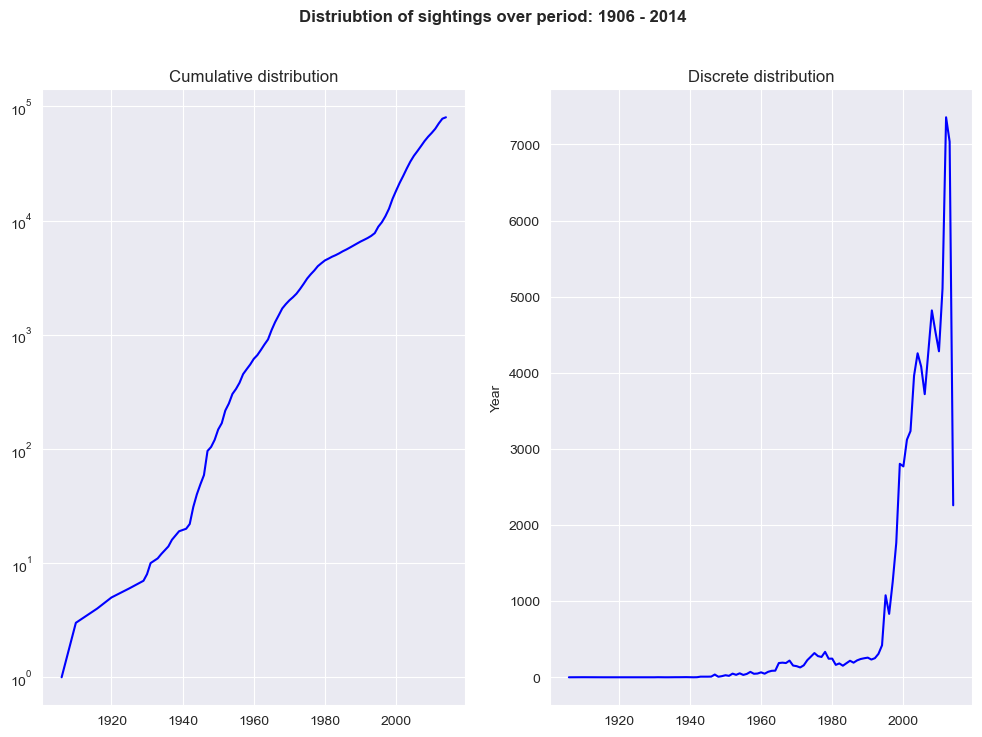

In [146]:
yrly_count = geo_df["Year"].value_counts().sort_index()
cum_count = yrly_count.cumsum()

fig, axs = plt.subplots(1,2,figsize=(12,8))

axs[0].set_yscale('log')
sns.lineplot(ax=axs[0], x=yrly_count.index, y=cum_count.values, color='blue')
axs[0].set_title(f"Cumulative distribution")

axs[1].set_yscale('linear')
sns.lineplot(yrly_count, ax=axs[1],color='blue')
axs[1].set_title(f"Discrete distribution")

fig.suptitle(f"Distriubtion of sightings over period: {min(yrly_count.index)} - {max(yrly_count.index)}", fontweight='bold')

sns.set_style("darkgrid")
plt.show()

A possible point of interest could come in seeing how the durations of reported events could vary based on the nature of the object. First,to make plotting easier, create new columns for the duration in minutes and hours. And with these, a good practice is to check the overall nature of the feature. So running `.describe()` is a good idea

In [147]:
df['length_of_encounter_mins'] = df['length_of_encounter_seconds']/60
df['length_of_encounter_hrs'] = df['length_of_encounter_seconds']/3600

df['length_of_encounter_hrs'].describe()


count    8.032800e+04
mean     2.504815e+00
std      1.722867e+02
min      2.777778e-07
25%      8.333333e-03
50%      5.000000e-02
75%      1.666667e-01
max      2.717667e+04
Name: length_of_encounter_hrs, dtype: float64

We can see that while the mean is potentially reasonable at around 2.5 hours, the minimum and maximum values suggest theres so irregularities in the data that are unphysical. As such, we can apply some masking to the series to select only duration ranges we'd deem as reasonable, and plot the histogram as a function of the reported UFO shape.

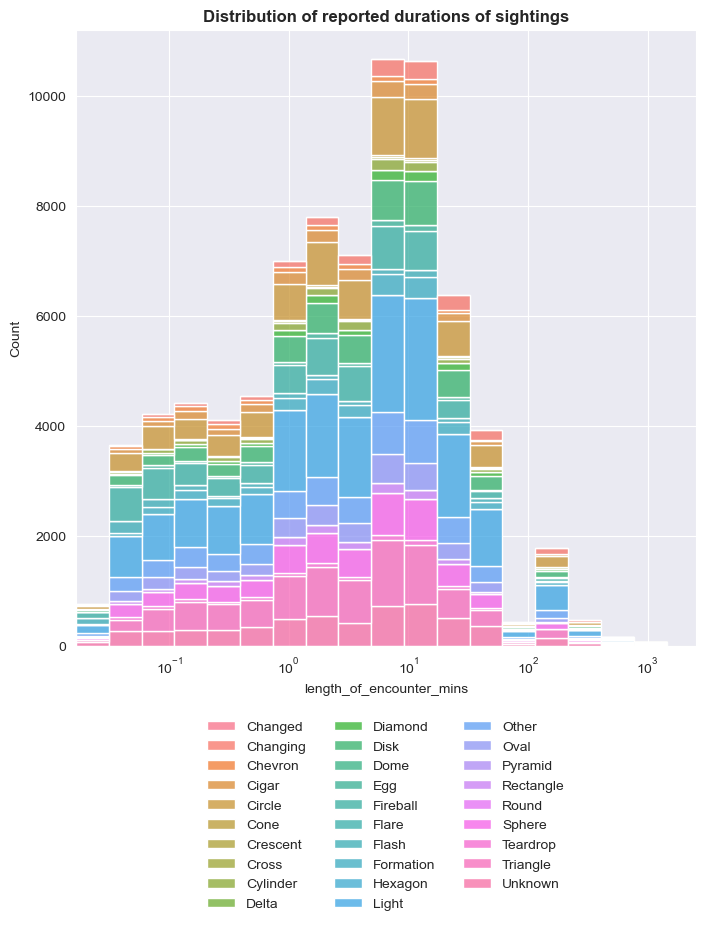

In [148]:
mask = (df['length_of_encounter_hrs'] <= 24) & (df['length_of_encounter_seconds'] >= 1)

fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(data=df[mask],x='length_of_encounter_mins',bins=18,log_scale=True, hue='UFO_shape', multiple='stack')
plt.title("Distribution of reported durations of sightings", fontweight='bold')
plt.xlim(xmin=min(df[mask]['length_of_encounter_mins']))
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, -0.45), ncol=3, title=None, frameon=False,
)

It could be interesting to look at the possible relations of the sightings in terms of monthly distibutions (or even finer, in terms of seasonal sighting counts). The difference in day-night lengths over the course of the year could relay insight into how the likelihood of sightings changes. Are UFO sightings more likely during longer nights in winter due to the hours of darkness lasting longer? Or could the longer hours of daylight during the summer months when more people are outside for longer into the evening potentially mean more possible sightings of phenomenon in the sky?

Text(0.5, 1.0, 'Distibution of sightings aggregared by month')

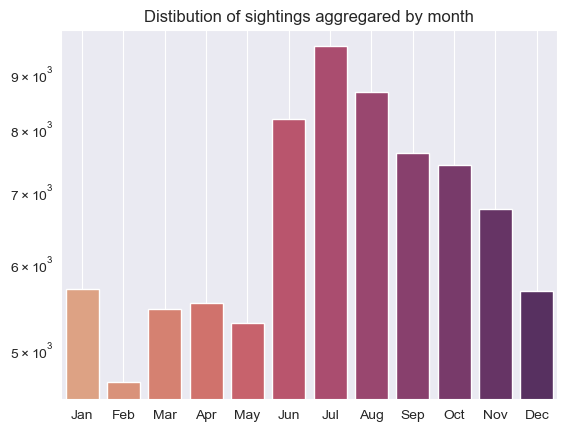

In [149]:
def find_season(latitude, Month):
    if latitude < 0:
        season_month_south = {
            12:'Summer', 1:'Summer', 2:'Summer',
            3:'Autumn', 4:'Autumn', 5:'Autumn',
            6:'Winter', 7:'Winter', 8:'Winter',
            9:'Spring', 10:'Spring', 11:'Spring'}
        return season_month_south.get(Month)
        
    elif latitude > 0:
        season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month_north.get(Month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')


month_values = df.value_counts('Month').sort_index(ascending=True)

inds = []
for i in month_values.index.values:
     inds.append(calendar.month_abbr[i])

month_values.index = inds

sns.barplot(x=month_values.index, y=month_values.values, palette='flare')
plt.yscale('log')
plt.grid(True)
plt.title('Distibution of sightings aggregared by month')

Interestingly, we see that most of the recorded sightings were in the month of July, with the adjacent months also showing some of the highest report numbers. This could lend more to the idea that the months with longer periods of fine weather, and where people are out longer into the evenings could correlate with higher likelihood of observing a UFO
However, it's also good to account for the differences in Hemispheres when thinking about this. If we take the reported month of the sighting, and encode it with the corresponding season (dependant on the latitude of the observing region), then we can see more how perhaps the long summer days might have higher counts than the darker winter months where people tend to stay inside much more

Text(0.5, 1.0, 'Distribution of UFO sightings aggregated by hemispheric season')

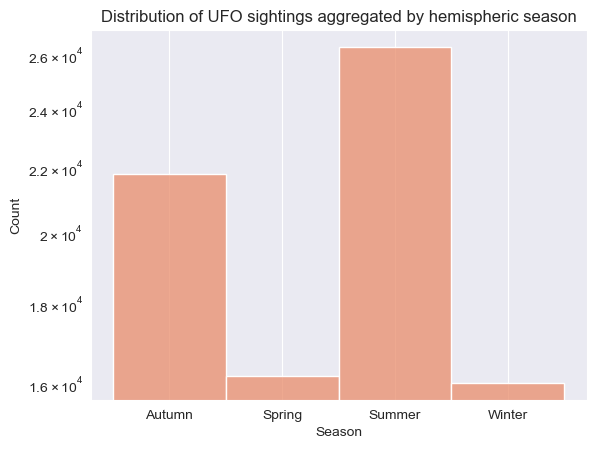

In [150]:
season_month_north = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}


for index, row in df.iterrows():
    df.loc[index,'Season'] = find_season(row.latitude, row.Month)



sns.histplot(df.Season)
sns.set_style("darkgrid")
plt.yscale('log')
plt.title('Distribution of UFO sightings aggregated by hemispheric season')

<Axes: title={'center': 'Distribution of reported UFO shapes'}, xlabel='UFO_shape', ylabel='count'>

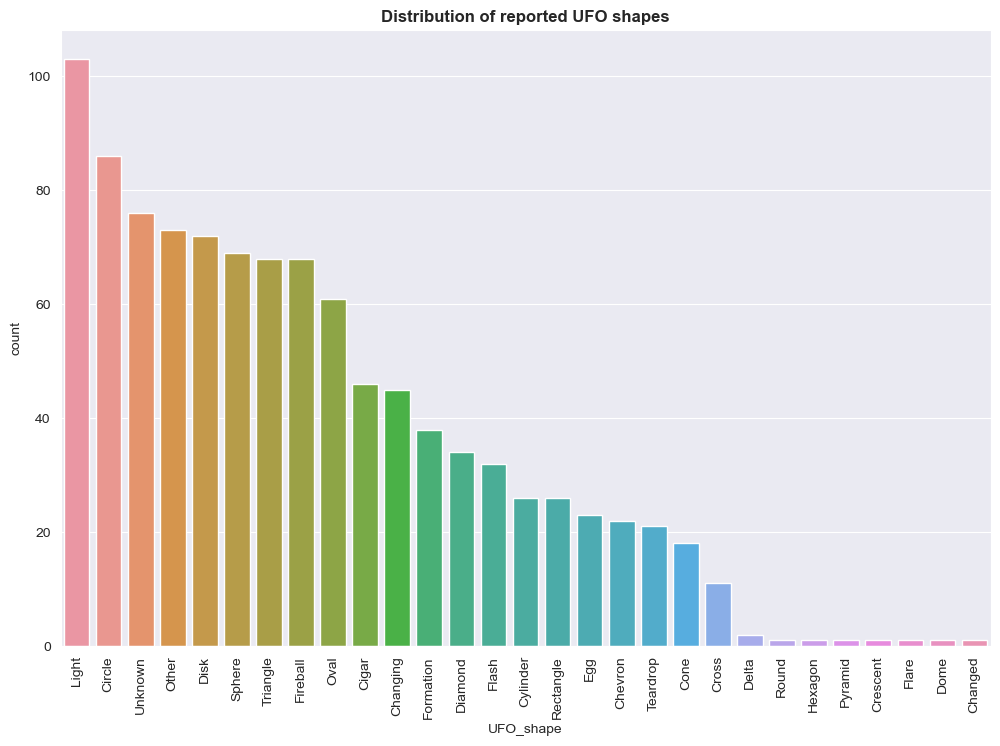

In [151]:
shapes = data_frame=df[['UFO_shape', 'Country']].value_counts().to_frame().reset_index()
shapes = shapes.rename(columns={0:'count'}).sort_values('count')

plt.figure(figsize=(12,8))
plt.xticks(rotation=90)
plt.title('Distribution of reported UFO shapes', fontweight='bold')
sns.countplot(data=shapes,x='UFO_shape',order=shapes['UFO_shape'].value_counts().index)


As another point of practice,

In [152]:
geo_US = geo_df[geo_df['Country'] == 'United States']
df_US = df[geo_df['Country'] == 'United States']

In [175]:
geo_US['Month_categorical'] = geo_US['Month'].apply(lambda x: calendar.month_abbr[x])

/Users/cuji/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [153]:
us_states_counts = pd.DataFrame({'State':df_US.value_counts('Region').to_frame().index.values, 'Count':df_US.value_counts('Region').values})
us_states_counts

,State,Count
0,California,9625
1,Washington,4270
2,Florida,4200
3,Texas,3684
4,New York,3235
...,...,...
738,Guayas,0
739,Guerrero,0
740,Gujarat,0
741,Gördes,0


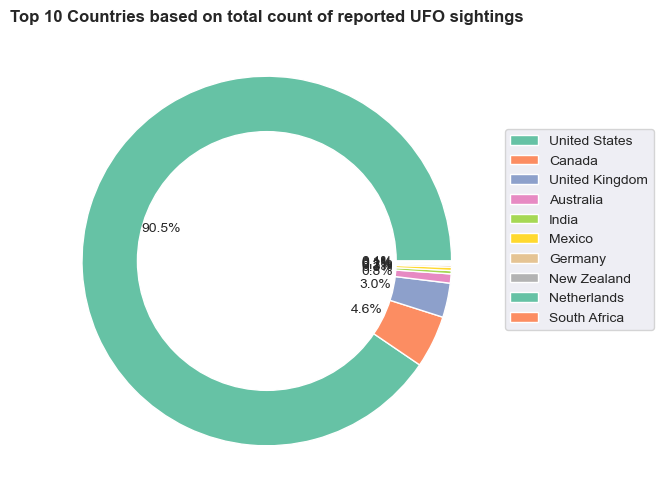

In [154]:
top10 = df['Country'].value_counts().head(10)

labels = top10.index.values
vals = top10.values
data = pd.DataFrame({"Country":labels,"Counts":vals})

plt.figure(figsize=(6,6))
pie = plt.pie(vals, autopct='%1.1f%%', labeldistance=1.05, colors=sns.color_palette('Set2')
)
patch = pie[0]
text = pie[2]

my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


plt.title('Top 10 Countries based on total count of reported UFO sightings', fontweight='bold')
plt.legend(patch, labels, loc='best',  bbox_to_anchor=(1, 0, 0.2, 0.8))

In [155]:
us_state_counts = geo_US.value_counts("Region").to_frame()
us_states_counts

,State,Count
0,California,9625
1,Washington,4270
2,Florida,4200
3,Texas,3684
4,New York,3235
...,...,...
738,Guayas,0
739,Guerrero,0
740,Gujarat,0
741,Gördes,0


In [156]:
for index, row in  us_state_counts.iterrows():
    if index not in geo_overlay_US.name.values:
        us_state_counts = us_state_counts.drop(index)


us_state_counts = pd.DataFrame({"State":us_state_counts.index.values, "Count":us_state_counts.values.ravel()})

In [198]:
my_USA_map = 'UFO-Sightings-Analysis\\us-states.json'
my_USA_map = os.getcwd() + '/us-states.json'
with open(my_USA_map) as json_file:
    json_data_states = json.load(json_file)


map = folium.Map(location=[44, -103], zoom_start=4)

fc = folium.FeatureGroup(name="choropleth", show=False).add_to(map)
fm = folium.FeatureGroup(name="markers", show=False).add_to(map)


folium.Choropleth(geo_data=json_data_states,
                  name="Choropleth",
                  data=us_state_counts,
             columns=['State', 'Count'],
             key_on='feature.properties.name',
             legend_name="Number of sightings",
             fill_color='BuPu').add_to(map)




for index, row in geo_US.sample(200).iterrows():

   html = f"{row['Month_categorical']} - {row['Year']}:\n {row['Description']}".center(20," ")

   iframe = folium.IFrame(html,
                        width=200,
                        height=100)

   popup = folium.Popup(iframe,
                        max_width=220)


   folium.Marker(
      location=[row['latitude'], row['longitude']],
      name = "Markers",
      overlay = True,
      control = True,
      popup=popup,
   ).add_to(fm)

folium.LayerControl().add_to(map)


map

